In [2]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
from sklearn.model_selection import train_test_split
import pandas as pd
# augmentasi gambar
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Menetapkan batas waktu pelatihan
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

2.17.0
Mounted at /content/drive


In [3]:
# Contoh data gambar
base_dir = '/content/drive/MyDrive/Colab Notebooks/dataset'
image_paths = []
labels = []
train_dir = os.path.join(base_dir,'train')

for class_name in ['paper', 'rock', 'scissors']:
    class_dir = os.path.join(train_dir, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        image_paths.append(img_path)
        labels.append(class_name)



In [4]:
# Split dataset into training (60%) and validation (40%)
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.4, random_state=42)

In [5]:
print(len(X_train),len(X_val))
print(len(y_train),len(y_val))

1312 876
1312 876


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    #validation_split=0.3  # 40% untuk validation
    )
val_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_train, 'class': y_train}), # direktori data latih
    x_col='filename',
    y_col='class',
    target_size=(150,150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
    batch_size=32,
    class_mode='categorical', # menggunakan categorical karena klasifikasi lebih dari 2 kelas
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': X_val, 'class': y_val}), # direktori data validasi
    x_col='filename',
    y_col='class',
    target_size=(150,150), # mengubah resolusi gambar menjadi 150x150 piksel
    batch_size=32,
    class_mode='categorical',
)

Found 1312 validated image filenames belonging to 3 classes.
Found 876 validated image filenames belonging to 3 classes.


In [7]:
# Proses CNN
model = tf.keras.models.Sequential([
    Conv2D(32,(3,3),activation='relu', input_shape=(150,150,3)),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax') # 3 classes: paper, rock, scissors
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,203 (72.61 MB)

 Trainable params: 19,035,203 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 365s 8s/step - accuracy: 0.3597 - loss: 1.3284 - val_accuracy: 0.4281 - val_loss: 1.0277
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.4816 - loss: 1.0485 - val_accuracy: 0.4646 - val_loss: 1.0113
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.5448 - loss: 0.9869 - val_accuracy: 0.6518 - val_loss: 0.8528
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6454 - loss: 0.7949 - val_accuracy: 0.7466 - val_loss: 0.4928
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7421 - loss: 0.6186 - val_accuracy: 0.9269 - val_loss: 0.2636
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8228 - loss: 0.4679 - val_accuracy: 0.9932 - val_loss: 0.0833
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9062 - loss: 0.2607 - val_accuracy: 0.9886 - val_loss: 0.0574
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - accuracy: 0.9522 - loss: 0.1863 - val_accuracy: 0.9703 - val_l

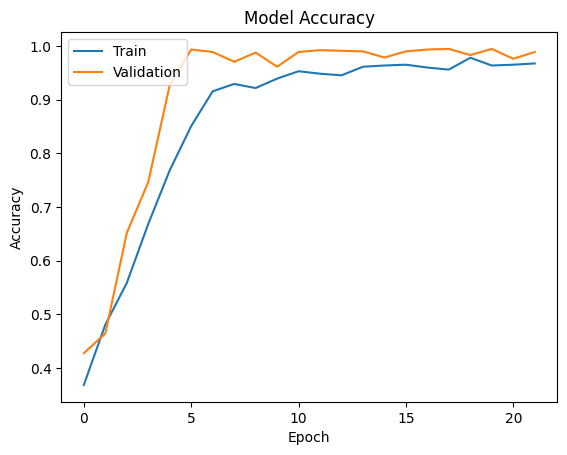

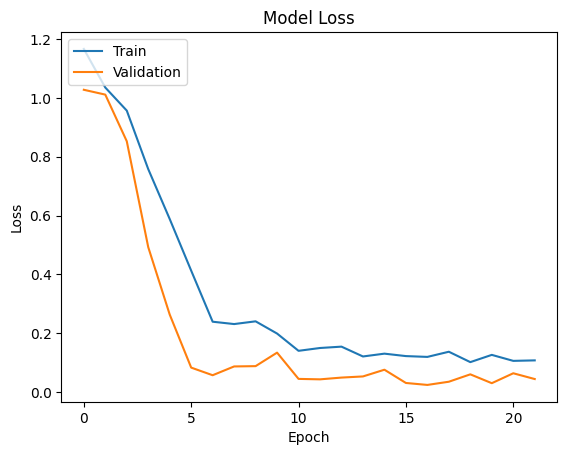

In [9]:


start_time = time.time()

model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // train_generator.batch_size,
    steps_per_epoch = None,
    validation_data=validation_generator,
    # validation_steps=validation_generator.samples // validation_generator.batch_size,
    validation_steps=None,
    epochs=100,  # Jumlah epoch (iterasi) pelatihan
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: (
            model.stop_training if (time.time() - start_time) > 1800 else None))  # 30 menit = 1800 detik
    ]
)

# Load history
history = model.history

# Plot akurasi pelatihan dan validasi
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# plot los pelatihan dan validasi
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
# model.save('model_gunting_batu_kertas_2.h5')

In [11]:


# Load model yang sudah dilatih
model_latih = model
# model_latih = tf.keras.models.load_model('/home/widi/htdocs/Artificial_Intelligence/1.Supervised/9.TugasAkhirKlasifikasi/model_gunting_batu_kertas_fix.h5')  # Ganti dengan nama file model Anda
class_names = ['paper','rock', 'scissors']  # Ganti dengan nama kelas sebenarnya

# Fungsi untuk melakukan prediksi
def predict_image(img_path):
  # Load gambar dan ubah ukurannya sesuai dengan input model
  img = image.load_img(img_path, target_size=(150, 150))
  # Ubah gambar menjadi array NumPy
  img_array  = image.img_to_array(img)
  # Tambahkan dimensi untuk batch
  img_array  = np.expand_dims(img_array , axis=0)
  # Normalisasi gambar (opsional, tergantung preprocessing saat pelatihan)
  img_array  /= 255.0

  # Melakukan prediksi
  predictions = model.predict(img_array)
  predicted_class = np.argmax(predictions[0])  # Mengambil kelas dengan probabilitas tertinggi
  confidence = predictions[0][predicted_class]  # Mengambil confidence dari prediksi

  # Get class names (assuming you have a list of class names)
  # class_names_rusak = ['rock', 'paper', 'scissors']
  class_names = ['paper', 'rock', 'scissors']

  # Menampilkan hasil prediksi
  print(f'Prediksi: {class_names[predicted_class]} dengan keyakinan {confidence:.2f}')
  # Menampilkan gambar
  img = image.load_img(img_path, target_size=(150, 150))
  plt.imshow(img)
  plt.title(f'Prediksi: {class_names[predicted_class]}')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Prediksi: paper dengan keyakinan 0.99


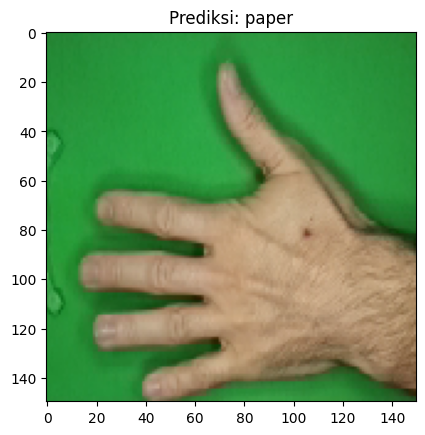

In [12]:
img_path1 = '/content/drive/MyDrive/Colab Notebooks/dataset/val/paper/14K62H4KG1hg5qiJ.png'
predict_image(img_path1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediksi: rock dengan keyakinan 0.88


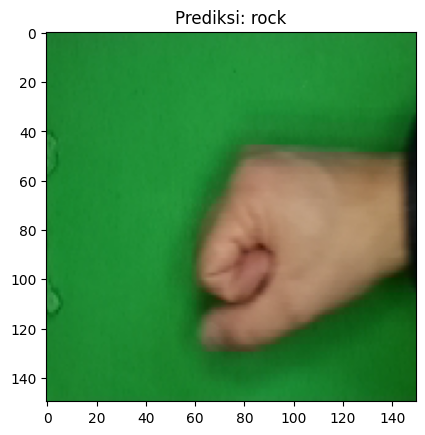

In [13]:
img_path2 = '/content/drive/MyDrive/Colab Notebooks/dataset/val/rock/1MOm36DHK0R8OfIC.png'
predict_image(img_path2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Prediksi: scissors dengan keyakinan 1.00


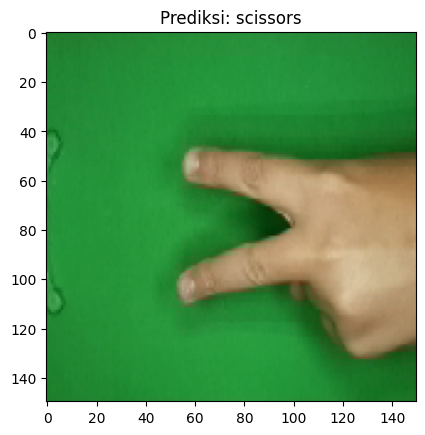

In [14]:
img_path3 = '/content/drive/MyDrive/Colab Notebooks/dataset/val/scissors/0Ug54ifXRqqlZS2Z.png'
predict_image(img_path3)

# Identitas Diri
 - Nama: Widi Arrohman
 - Username: widi_arrohman

 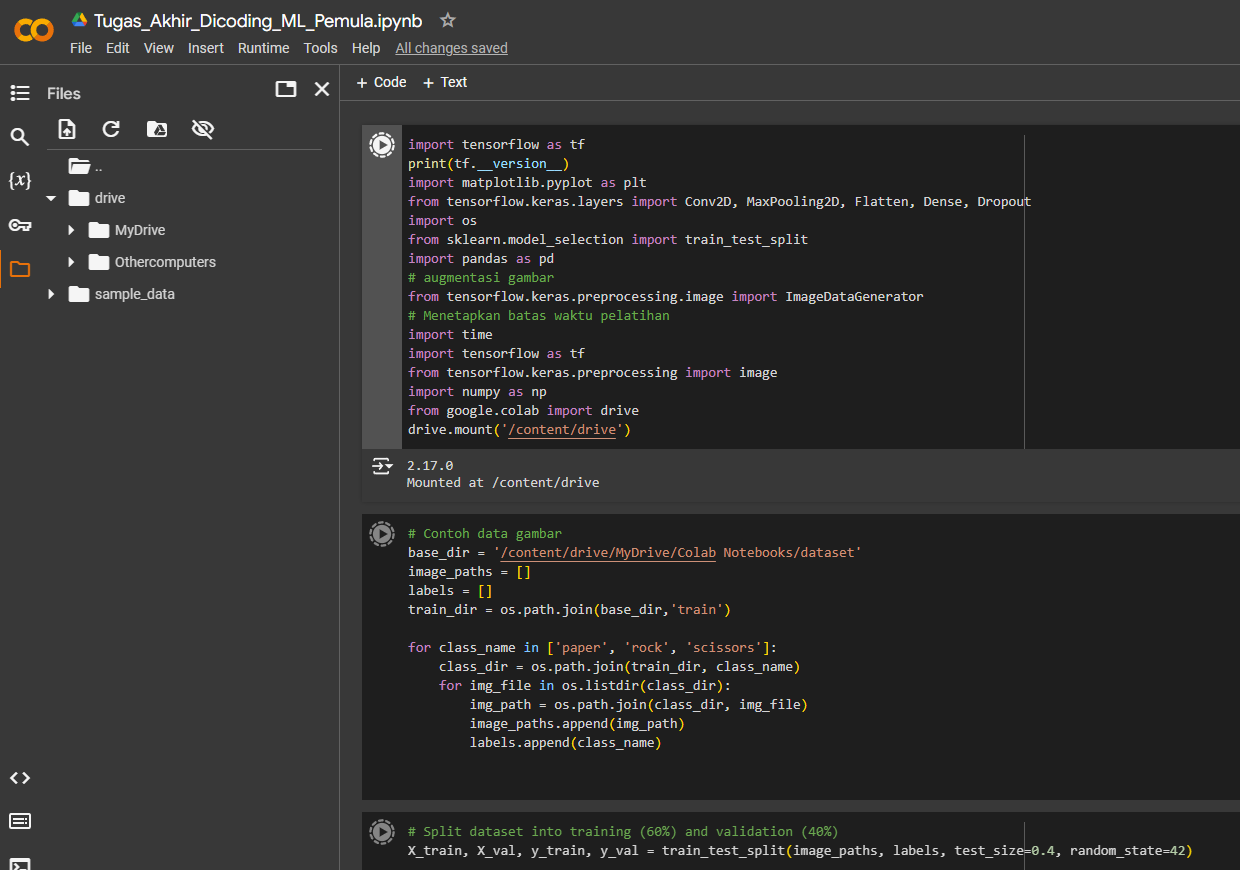